In [1]:
try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterator, *args, **kwargs):
        return iterator
import os, sys, glob, warnings, glob    
import numpy as np
import scipy as sp
from scipy import constants
from pylab import *
import joblib
import importlib
from importlib import reload
sys.path.append("/home/owhgabri/My_GitHub/pyTracker/tracker")
sys.path.insert(1, "/home/owhgabri/My_GitHub/pyTracker/tracker")
os.chdir('/home/owhgabri/My_GitHub/pyTracker')
print(os.getcwd())
print(joblib.__version__)

/home/owhgabri/My_GitHub/pyTracker
1.4.2


In [2]:
import scipy
import copy as cp

# ROOT
import ROOT as root

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import collections, colors, transforms

%matplotlib inline
%config InlineBackend.figure_format='retina'
# %matplotlib widget

import pprint

Welcome to JupyROOT 6.26/14


In [3]:
import kalmanfilter as KF
import utilities as Util
import trackfinder as TF
import datatypes
from datatypes import *

reload(TF)
reload(Util)

<module 'utilities' from '/home/owhgabri/My_GitHub/pyTracker/tracker/utilities.py'>

### Defining Useful Functions ### 

In [4]:
steel_height=3 # cm
Box_IP_Depth=8547 # cm   

wall_floor1 = (7000,8633.2)
wall_floor2 = (7000,8551.6)
wallMid1 = 6896.6
wallMid2 = 6998.2
floorMid1 = 8550.8
floorMid2 = 8632.4

y_bottoms = [8550, 8631.6]
z_fronts = [6895.8, 6997.4]
x_lims = (-1950, 1950)
thickness = 1.6

In [12]:
def SortByTime(points):
    """
    Sorts list hits by time
    A hit is of the form (x,y,z,t)
    """
    if len(points) <= 1:
        return points
    pivot = points[len(points) // 2]
    left = []
    middle = []
    right = []
    for point in points:
        if point[-1] < pivot[-1]:
            left.append(point)
        elif point[-1] > pivot[-1]:
            right.append(point)
        elif point[-1] == pivot[-1]:
            middle.append(point)
    return SortByTime(left) + middle + SortByTime(right)


def GoingUp(points):
    """
    Takes a sorted list of points and check if it is going up.
    If it is, return True
    """
    for i in range(1, len(points)):
        if points[i-1][1] > points[i][1]:
            return False
    return True


def ProjectionTime(track, points, layer):
    """
    Takes a track and its SORTED list of points
    closest is true if you want to check in the closest wall/floor,
    false if you wanna check in the farther wall/floor
    Returns the time at which the track is 
    projected to enter the wall or floor
    Given point is (x,y,z,t)
    """
    if layer == 0:# Walls
        if track.Ay == 1: # Horizontal layer track 
            return track.At/track.Az*(wallMid1 - points[0][2]) + points[0][3]
        else: # Vertical layer track
            return track.At*(wallMid1 - points[0][2]) + points[0][3]
    elif layer == 1:
        if track.Ay == 1: # Horizontal layer track
            return track.At/track.Az*(wallMid2 - points[0][2]) + points[0][3]
        else: # Vertical layer track
            return track.At*(wallMid2 - points[0][2]) + points[0][3]
    elif layer == 2: # Floors
        if track.Ay == 1: # Horizontal layer track
            return track.At*(floorMid1 - points[0][1]) + points[0][3]
        else: # Vertical layer track
            return track.At/track.Ay*(floorMid1 - points[0][1]) + points[0][3]
    elif layer == 3: 
        if track.Ay == 1: # Horizontal layer track
            return track.At*(floorMid2 - points[0][1]) + points[0][3]
        else: # Vertical layer track
            return track.At/track.Ay*(floorMid2 - points[0][1]) + points[0][3]


def ProjectionPoint(track, points, t):
    """
    Returns where the track is projected to be at time t.
    points is the list of hits from the track sorted by time
    Returns an empty array if out of the detector
    """
    if track.Ay == 1: #Horizontal layer track
        xf = points[0][0] + track.Ax/track.At*(t - points[0][3])
        yf = points[0][1] + 1/track.At * (t - points[0][3])
        zf = points[0][2] + track.Az/track.At*(t - points[0][3])
    else: # Vertical layer track 
        xf = points[0][0] + track.Ax/track.At*(t - points[0][3])
        yf = points[0][1] + track.Ay/track.At * (t - points[0][3])
        zf = points[0][2] + 1/track.At*(t - points[0][3])
    if yf < y_bottoms[0] or xf < x_lims[0] or xf > x_lims[1] or zf < z_fronts[0]:
        return None # Out of bounds of detector
    return np.array((xf,yf,zf))


def ProjectionCovariance(track, points, t):
    """
    Returns the projected covariance of x,y,z at time t.
    covariance is x,z,t,Ax,Az,At if horizontal track, or 
    x,y,t,Ax,Ay,At if vertical track.
    points is sorted by time
    """
    dt = t - points[0][3]
    if track.Ay == 1: # Horizontal track
        Jac = np.array([[1, 0, -track.Ax/track.At, dt/track.At, 0, -track.Ax*dt/track.At**2],
                        [0, 0, -1/track.At, 0, 0, -dt/track.At**2],
                        [0, 1, -track.Az/track.At, 0, dt/track.At, -track.Az*dt/track.At**2]])
    else: 
        Jac = np.array([[1, 0, -track.Ax/track.At, dt/track.At, 0, -track.Ax*dt/track.At**2],
                        [0, 1, -track.Ay/track.At, 0, dt/track.At, -track.Ay*dt/track.At**2],
                        [0, 0, -1/track.At, 0, 0, -dt/track.At**2]])    
    return Jac@track.cov@Jac.T

    
def GetLayer(point):
    """
    Returns the layer index that a xyz point is in
    """
    for i in range(len(z_fronts)):
        if point[2] > z_fronts[i] and point[2] < z_fronts[i] + thickness:
            return i
    for i in range(len(y_bottoms)):
        if point[1] > y_bottoms[i] and point[1] < y_bottoms[i] + thickness:
            return i + len(z_fronts)
    return -1


def GetChiSquared(hit, track):
    """
    Get the chi squared between a track projection and the hit
    """
    TrackPoints = SortByTime(track.hits_filtered)
    hit_pos = np.array((hit.x, hit.y, hit.z))
    hit_err = np.array((hit.x_err, hit.y_err, hit.z_err))
    proj_time = ProjectionTime(track, TrackPoints, hit.layer)
    proj_point = ProjectionPoint(track,TrackPoints, proj_time)
    if proj_point is None:
        return None
    proj_cov = ProjectionCovariance(track, TrackPoints, proj_time)
    proj_cov += np.diag(hit_err)
    residual = proj_point - hit_pos 
    try:
        inv_cov = np.linalg.inv(proj_cov)
    except:
        return None
    return residual.T @ inv_cov @ residual


def GetDistance(point1, point2):
    """
    Get the distance between two points (x,y,z)
    """
    return np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2 + (point1[2]-point2[2])**2)




In [13]:
data_top_dir = f"/home/owhgabri/My_GitHub/data/Reconstruction/10xCosmicBackground"
pathList=[]

for rootFile, dirs, files in os.walk(data_top_dir):
    for filename in files:
        if ".pkl" in filename:
            pathList.append(os.path.join(rootFile, filename))


print(len(pathList))

98


### Getting Chi2 and Distance Distribution ###

In [14]:
chi2s = []
distances = []
times = []
nvertices = 0
for f in pathList:
    events=joblib.load(f)
    file_hits = events["hits"]
    file_tracks = events["tracks"]
    file_vertices = events["vertices"]
    for i in range(len(file_hits)):
        hits= file_hits[i]
        tracks = file_tracks[i]
        vertices = file_vertices[i]
        nvertices += len(vertices)
        # if len(vertices) == 0:
        #     continue
        wf_hits = []
        for hit in hits:
            if hit.layer < 4:
                wf_hits.append(hit)
        if len(wf_hits) == 0:
            continue
        # for vertex in vertices:
        #     v_tracks = []
        #     for index in vertex.tracks:
        #         v_tracks.append(tracks[index])
        for track in tracks:
            min_hit = None
            min_chi2 = None
            min_time = None
            min_point = None
            for hit in wf_hits:
                    TrackPoints = SortByTime(track.hits_filtered)
                    hit_pos = np.array((hit.x, hit.y, hit.z))
                    hit_err = np.array((hit.x_err, hit.y_err, hit.z_err))
                    proj_time = ProjectionTime(track, TrackPoints, hit.layer)
                    proj_point = ProjectionPoint(track,TrackPoints, proj_time)
                    if proj_point is None:
                        continue
                    cur_chi2 = GetChiSquared(hit,track)
                    if cur_chi2 is not None and (min_chi2 is None or cur_chi2 < min_chi2):
                        min_chi2 = cur_chi2
                        min_hit = hit
                        min_time = abs(proj_time - hit.t)
                        min_point = proj_point
            if min_hit is None:
                continue
            dist = GetDistance([min_hit.x,min_hit.y,min_hit.z], min_point)
            chi2_red = min_chi2
            if chi2_red > 0 and chi2_red < 20:
                chi2s.append(chi2_red)
                distances.append(dist)
                times.append(min_time)

1.9701501916201585
[0.00436797]


Text(0, 0.5, 'Reduced chi2')

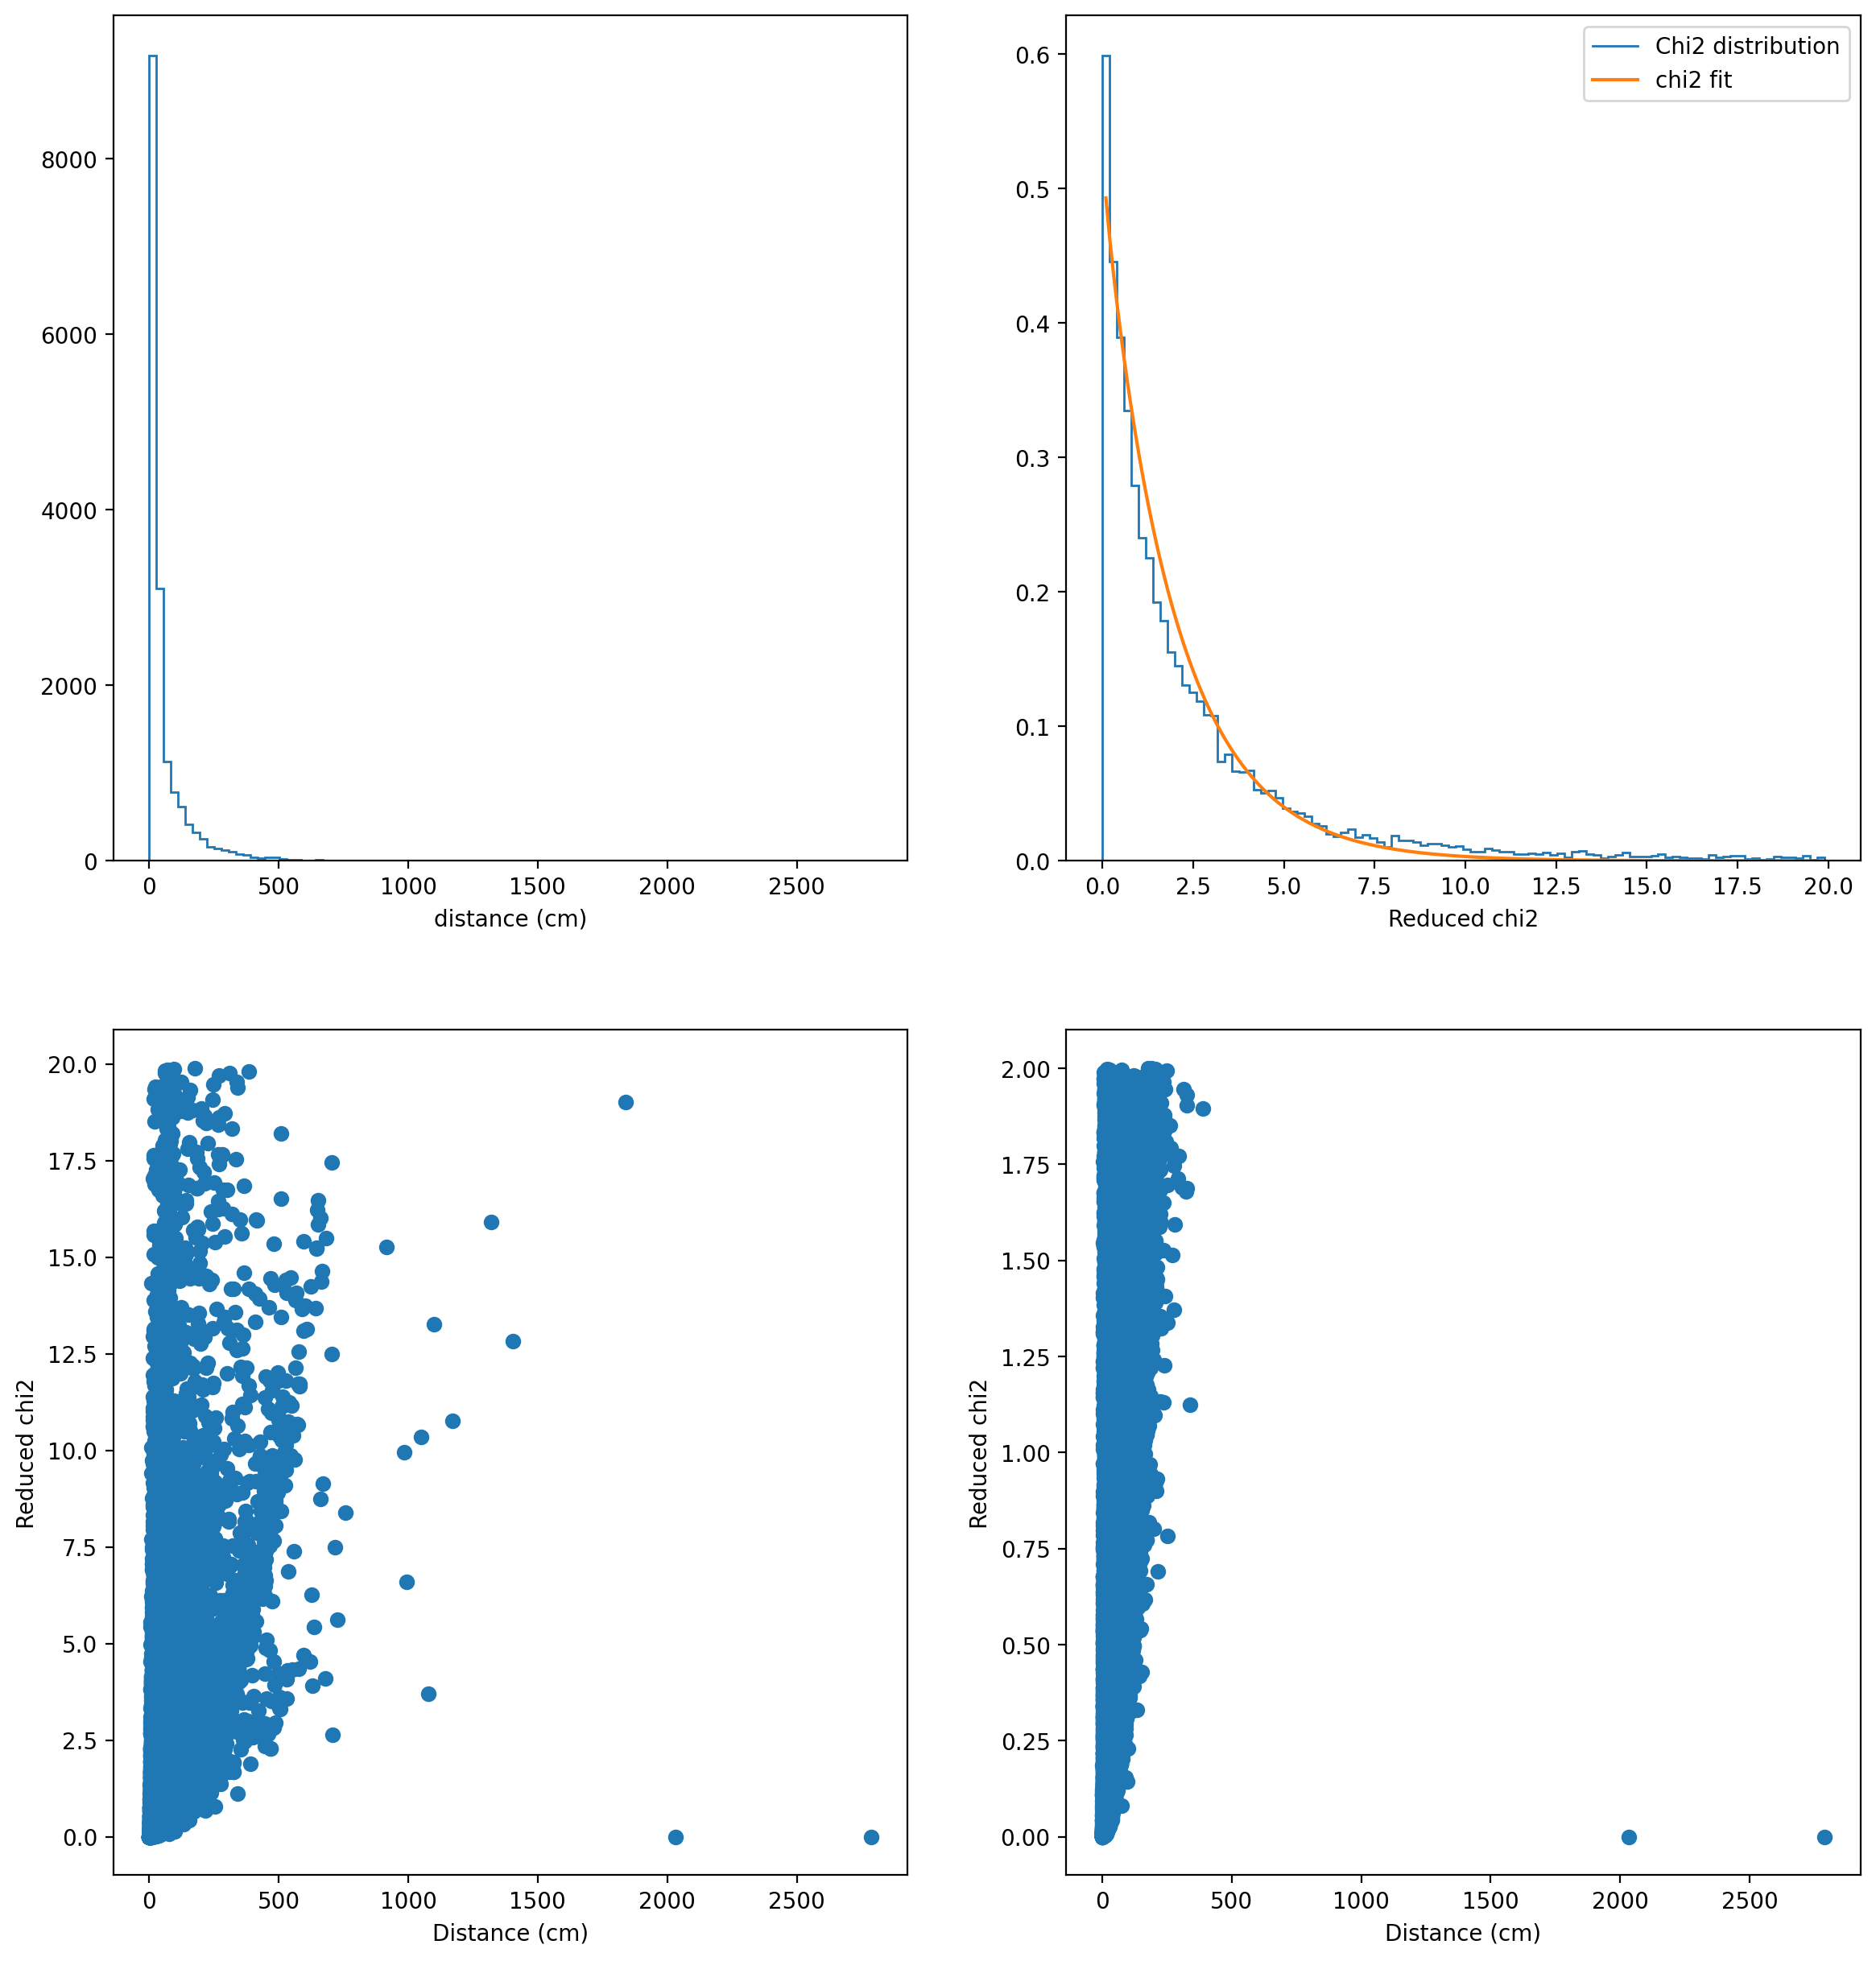

In [15]:
fig,axs=plt.subplots(2,2,figsize=(14,15))
axs=axs.flatten().tolist()

zoomedchis = []
zoomeddist = []
for i in range(len(chi2s)):
    if chi2s[i] < 2:
        zoomedchis.append(chi2s[i])
        zoomeddist.append(distances[i])

distancesCounts, distancesBins = np.histogram(distances, bins=100)
chi2Counts, chi2Bins = np.histogram(chi2s, bins=100)

binsize = chi2Bins[1] - chi2Bins[0]
chi2Counts = chi2Counts/(sum(chi2Counts)*binsize)

popt, pcov = sp.optimize.curve_fit(lambda x,k: sp.stats.chi2.pdf(x,k,0,2), chi2Bins[:-1], chi2Counts, sigma=sqrt(chi2Counts))
print(popt[0])
print(np.sqrt(pcov[0]))

domain = np.arange(0, chi2Bins[-1], 0.1)
chi2_fit = sp.stats.chi2.pdf(domain, popt[0], 0, 1)

axs[0].stairs(distancesCounts[:int(len(distancesCounts)/1)], distancesBins[:int(len(distancesCounts)/1) + 1])
axs[0].set_xlabel("distance (cm)")
axs[1].stairs(chi2Counts[:int(len(chi2Counts)/1)], chi2Bins[:int(len(chi2Counts)/1) + 1], label="Chi2 distribution")
axs[1].plot(domain[:int(len(domain)/1)], chi2_fit[:int(len(domain)/1)], label="chi2 fit")
# axs[1].set_yscale('log')
axs[1].legend()
axs[1].set_xlabel("Reduced chi2")
axs[2].scatter(distances, chi2s)
axs[2].set_xlabel("Distance (cm)")
axs[2].set_ylabel("Reduced chi2")
axs[3].scatter(zoomeddist, zoomedchis)
axs[3].set_xlabel("Distance (cm)")
axs[3].set_ylabel("Reduced chi2")

### Time Distribution for low Chi2 values ###

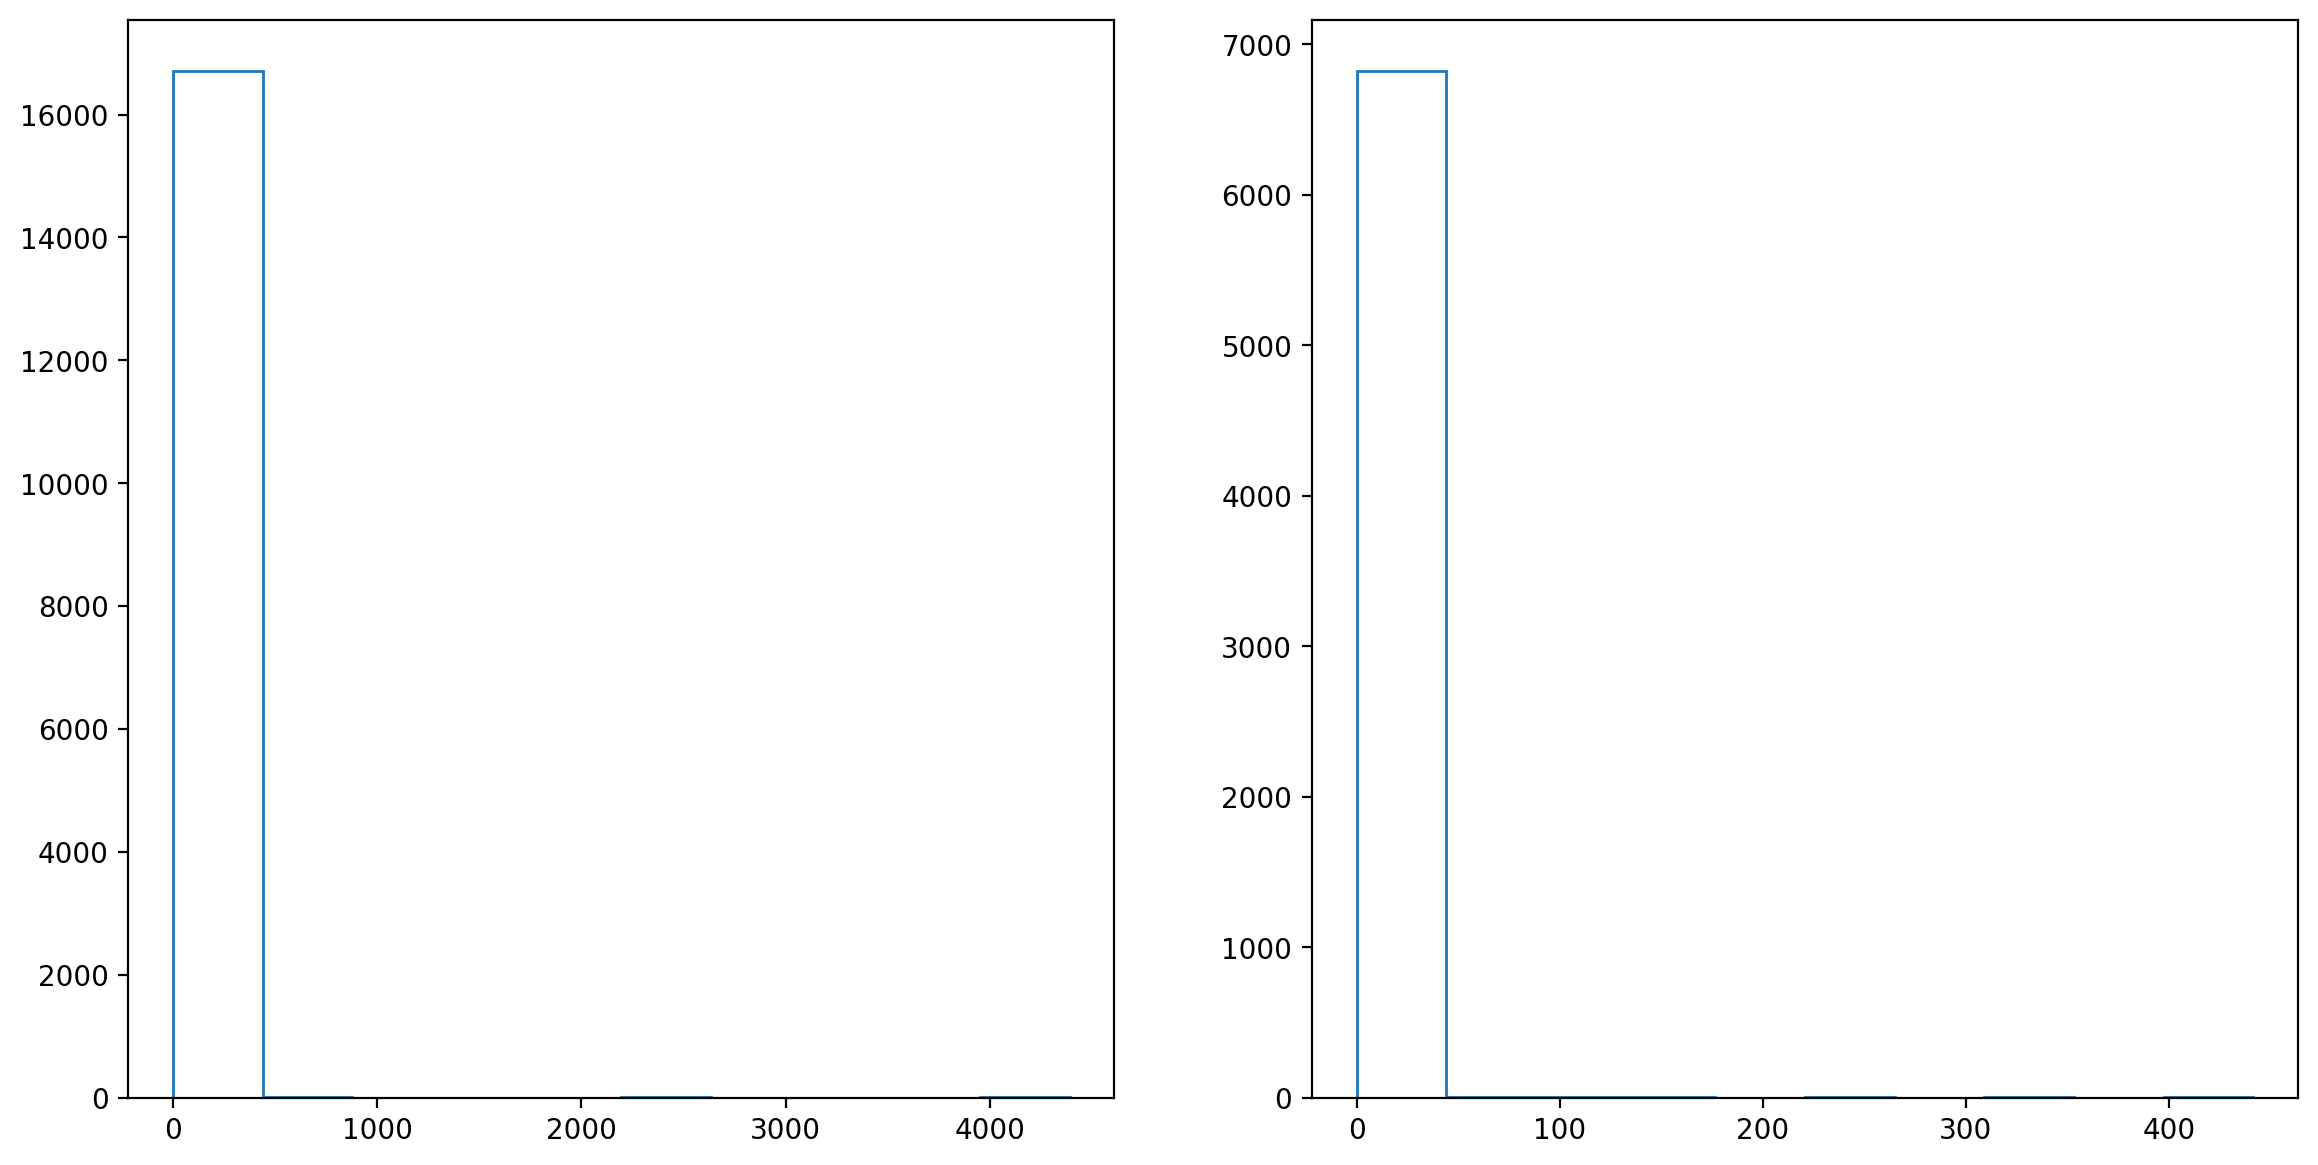

In [9]:
fig,axs=plt.subplots(1,2,figsize=(14,7))
axs=axs.flatten().tolist()

filtered_times = []
for i in range(len(chi2s)):
    if chi2s[i] < 1:
        filtered_times.append(times[i])

timesCounts, timesBins = np.histogram(times)
filteredCounts, filteredBins = np.histogram(filtered_times)

axs[0].stairs(timesCounts, timesBins)
axs[1].stairs(filteredCounts, filteredBins)



### Implementing Veto: Track Veto Efficiency ###

In [ ]:
cutoffs = [1,2,5,10,15,20,50,100]

chi2s = []
distances = []
times = []
nvertices = 0
for cut in cutoffs:
    for f in pathList:
        events=joblib.load(f)
        file_hits = events["hits"]
        file_tracks = events["tracks"]
        file_vertices = events["vertices"]
        for i in range(len(file_hits)):
            hits = file_hits[i]
            tracks = file_tracks[i]
            vertices = file_vertices[i]
            nvertices += len(vertices)
            if len(vertices) == 0:
                continue
            wf_hits = []
            for hit in hits:
                if hit.layer < 4:
                    wf_hits.append(hit)
            if len(wf_hits) == 0:
                continue
            for track in tracks:
                min_hit = None
                min_chi2 = None
                min_time = None
                min_point = None
                for hit in wf_hits:
                        TrackPoints = SortByTime(track.hits_filtered)
                        hit_pos = np.array((hit.x, hit.y, hit.z))
                        hit_err = np.array((hit.x_err, hit.y_err, hit.z_err))
                        proj_time = ProjectionTime(track, TrackPoints, hit.layer)
                        proj_point = ProjectionPoint(track,TrackPoints, proj_time)
                        if proj_point is None:
                            continue
                        cur_chi2 = GetChiSquared(hit,track)
                        if cur_chi2 is not None and (min_chi2 is None or cur_chi2 < min_chi2):
                            min_chi2 = cur_chi2
                            min_hit = hit
                            min_time = abs(proj_time - hit.t)
                            min_point = proj_point
                if min_hit is None:
                    continue
                dist = GetDistance([min_hit.x,min_hit.y,min_hit.z], min_point)
                chi2_red = min_chi2
                if chi2_red > 0 and chi2_red < 20:
                    chi2s.append(chi2_red)
                    distances.append(dist)
                    times.append(min_time)